# MAC0318 Introdu√ß√£o √† Programa√ß√£o de Rob√¥s M√≥veis

## Planejamento de movimento

Um problema planejamento de movimento √© composto por

- Um espa√ßo de trabalho $W$, particionado em espa√ßo livre $W_\text{free}$ e espa√ßo obstru√≠do $W_\text{obst}$
- Uma fun√ß√£o de ocupa√ß√£o que mapeia cada configura√ß√£o do ve√≠culo em uma regi√£o do espa√ßo de trabalho: $Occ: q \mapsto Occ(q) \subset W$
- Um espa√ßo de configura√ß√µes $C$, do qual obtemos o espa√ßo de configura√ß√µes livres $C_\text{free} = \{ q \in C \mid Occ(q) \subseteq W_\text{free} \}$
- Um funcional de custo $J(\tau)$ que associa a cada trajet√≥ria $\tau: [0,1] \rightarrow \mathbb{R}$ um valor real indicando uma penalidade
- Configura√ß√µes inicial $q_i$ e final $q_f$

O Objetivo √© encontrar uma solu√ß√£o para o seguinte problema de otimiza√ß√£o
$$
\arg\min J(\tau) \text{ s.a. } \tau(0)=q_i, \tau(1)=q_f, \tau(\alpha) \in C_\text{free}
$$

## Plajenamento de trajet√≥ria para o rob√¥ diferencial no plano

No caso do rob√¥ de dire√ß√£o diferencial no plano, o problema de planejamento de movimento pode ser decomposto em duas etapas:

1. Determinar trajet√≥ria de refer√™ncia $r(t)$, indicando a pose desejada para cada instante de tempo $t$
2. Determinar regra de controle $u(t)$ para seguir trajet√≥ria $r(t)$

A primeira etapa pode ser simplificada para fornecer como refer√™ncia uma curva no plano, de forma que a segunda etapa se encarregue de projetar um controlador (PID) para um rob√¥ seguidor de tal trajet√≥ria. 

<figure style="text-align:center;">
    <img src="img/trajectory.png" width="600">
</figure>

Vamos assumir que a configura√ß√£o do rob√¥ √© dada por sua pose $q = \begin{bmatrix} x & y & \theta \end{bmatrix}$ e que os obst√°culos s√£o representados como pol√≠gonos, especificados por seus v√©rtices. Vamos tamb√©m desprezar as dimens√µes do rob√¥, ou seja, vamos assumir um rob√¥ pontual e portanto que $Occ(q)=\begin{bmatrix} q_x & q_y \end{bmatrix}^t$. Essa hip√≥tese pode ser removida aumentando-se as dimens√µes do obst√°culos com as do rob√¥ (mas vamos ignorar tal passo aqui por simplicidade).

A etapa 1 pode ser ent√£o formalizada como:
- Espa√ßo de trabalho $W \subseteq \mathbb{R}^2$ e espa√ßo obstru√≠do $W_\text{obst} = W_1 \cup \dotsb \cup W_m$, onde cada $W_j$ √© um pol√≠gono especificado pela lista de v√©rtices $v \in W$.
- Espa√ßo de configura√ß√£o $C=\text{SE}(2)$
- Custo $J(\tau)$ dado pelo comprimento da curva $\begin{bmatrix} q_x(\alpha) & q_y(\alpha) \end{bmatrix}^t$ para $q = \tau(\alpha)$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Espa√ßo de trabalho: regi√£o retangular
largura = 1189
altura = 841

In [3]:
# Obst√°culos: lista de listas de v√©rtices de pol√≠gonos
O = [
# L
 np.array(
     [[179.917,  74.083, 412.750, 470.958, 243.417, 296.333],   # Coordenadas x
      [338.667, 592.083, 703.792, 582.083, 497.417, 381.000]]), # Coordenadas y
# Tri√¢ngulo
 np.array(
     [[793.750, 1095.375, 1079.5],
      [508.000,  730.250,  418.042]]),
# Pent√°gono
 np.array(
     [[518.583, 349.250, 497.417, 746.125, 719.667],
      [ 58.208, 248.708, 433.917, 391.583, 132.292]])
]

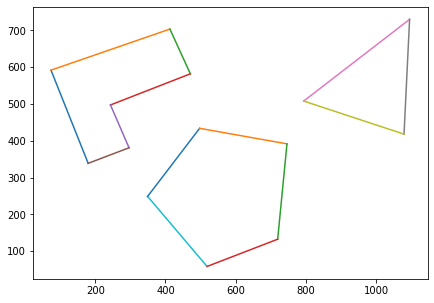

In [4]:
# Vamos exibir o espa√ßo de configura√ß√µes com os obst√°culos
ar = largura/altura
plt.figure(figsize=(5*ar,5))
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]])
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]])        

## Campos Potenciais

Nessa abordagem, encaramos o problema de planejamento de trajet√≥ria como o deslocamento de uma part√≠cula pontual de massa $m$ sujeita a um campo potencial $U: \mathbb{R}^2 \rightarrow \mathbb{R}$. No instante $t$ a part√≠cula ocupa uma posi√ß√£o $q_t \in \mathbb{R}^2$ e √© sujeita a for√ßa
$$
F(q_t) = -\nabla U(q_t) \, .
$$

Se assumirmos que a particula possui massa unit√°ria, a equa√ß√£o acima nos d√° a acelera√ß√£o da particula para a dada posi√ß√£o.

A fun√ß√£o potencial √© definida como a soma de $K$ potenticais locais: 
$$
U(q) = \sum_{i=1}^K U_i(q) \, .
$$
Cada potencial $U_i$ √© da forma atratatora $U_\text{att}$, que faz a part√≠cula a se locomover em sua dire√ß√£o, ou da forma repulsora $U_\text{rep}$, que faz a part√≠cula se locomover na dire√ß√£o oposta.

### Potencial atrator

A forma mais simples de potencial atrativo se refere a um ponto atrator $a$, e √© dado pela equa√ß√£o:
$$
U_\text{att}(q,a) = \frac{K_\text{att}}{2}|| q-a ||^2 \, ,
$$
onde $|| q || = \sqrt{q_x^2 + q_y^2}$ denote a norma de um vetor euclideano e $K_\text{att}$ √© uma constante que regula a intensidade da atra√ß√£o.

In [303]:
# Potencial atrator de ponto a

k_att = 0.001

def U_att(x, y, a):
    " Potencial atrativo para ponto a. "
    dist = (x-a[0])**2 + (y-a[1])**2
    return 0.5*k_att*dist

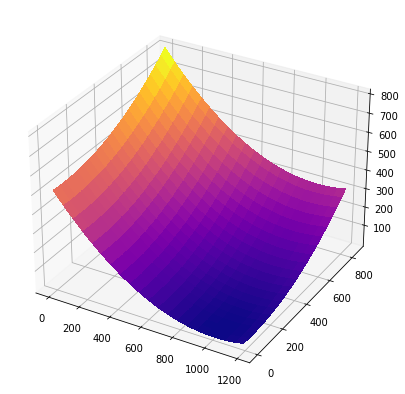

In [304]:
# Vamos calcular o potencial atrator ao ponto de destino

q_f   = np.array([1010, 70]) # posi√ß√£o final

# Vamos discretizar o espa√ßo em pontos igualmente espa√ßados para visualiza√ß√£o

xvalues = np.linspace(0,largura,100)

yvalues = np.linspace(0,altura,100)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

zvalues = U_att(xgrid, ygrid, q_f)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por efici√™ncia)
                       linewidth=0, antialiased=False);

### Potencial repulsor

O potencial respulsor em rela√ß√£o a um ponto $a$ √© similar, exceto que ele decresce quadraticamente com o inverso da dist√¢ncia entre os pontos:

$$
U_\text{rep}(q,a) = \frac{K_\text{rep}}{2} \frac{1}{||q-a||^2} \, ,
$$
onde $K_\text{rep}$ √© uma constante que regular a for√ßa. 

A fun√ß√£o acima atribui um valor positivo em todo o espa√ßo, embora desprez√≠vel para dist√¢ncias grandes. Para evitar que a soma de influ√™ncias pequenas de um n√∫mero grande de objetos se sobreponha a uma influ√™ncia de um objeto pr√≥ximo, podemos limitar a **zona de influ√™ncia** do ponto a um raio $\rho$:
$$
U_\text{rep}(q,a) = \begin{cases} \frac{K_\text{rep}}{2} \left(\frac{1}{||q-a||}-\frac{1}{\rho}\right)^2 & \text{se } ||q-a|| \leq \rho\\
0 & \text{se } ||q-a|| > \rho \end{cases}
$$

O potencial repulsor em rela√ß√£o a um segmento de reta √© dado pelo valor $U(q,n)$, onde $n$ √© o ponto mais pr√≥ximo ao segmento, ou seja, o ponto do segmento que minimiza $||q-n||$. Note que na f√≥rmula acima s√≥ precisamos conhecer a dist√¢ncia entre $q$ e $n$. O potencial repulsor em rela√ß√£o a um obst√°culo (pol√≠gono) √© o valor $U(q,n)$ onde $n$ √© o ponto de uma aresta do obst√°tculo mais pr√≥ximo a $q$.


In [305]:
# Potencial repulsor de ponto a

k_rep = 500.0

rho = 50.0 # raio de influ√™ncia

def U_rep_obs(x, y, o):
    " Potencial repulsivo para pol√≠gno o. "
    dist = np.Infinity*np.ones(x.shape)    
    # Encontra menor dist√¢ncia a aresta de pol√≠gono
    a = o[:,-1]
    for i in range(o.shape[1]):
        b = o[:,i]
        # proje√ß√£o do ponto (x,y) na reta que passa por ab
        t = ((x-a[0])*(b[0]-a[0]) + (y-a[1])*(b[1]-a[1]))/((b[0]-a[0])**2 + (b[1]-a[1])**2)
        # limite nas extremidades do segmento
        t[t < 0] = 0.0
        t[t > 1] = 1.0
        # ponto n mais pr√≥ximo na aresta
        nx = a[0] + t*(b[0]-a[0])
        ny = a[1] + t*(b[1]-a[1])
        # dist√¢ncia entre (x,y) e n
        d = np.sqrt((x-nx)**2 + (y-ny)**2)
        # menor dist√¢ncia a objeto?
        dist = np.minimum(d, dist)
        # pr√≥xima aresta
        a = b
    # Calcula potencial repulsivo
    u = 0.5*k_rep*(1/dist-1/rho)**2
    # valor fora do raio de influ√™ncia deve ser zero
    u[ dist >= rho ] = 0.0
    return u

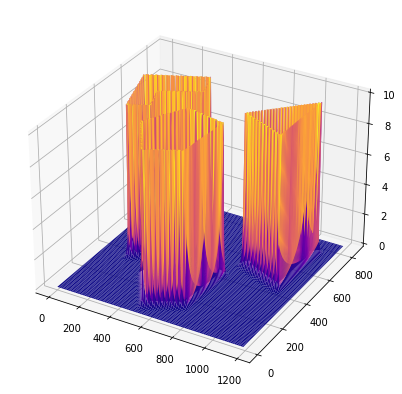

In [306]:
# Vamos calcular o potencial repulsor em rela√ß√£o a cada v√©rtice dos pol√≠gonos

xvalues = np.linspace(0,largura,500)

yvalues = np.linspace(0,altura,500)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

zvalues = np.zeros(xgrid.shape)
for o in O:
    zvalues += U_rep_obs(xgrid, ygrid, o)

# print(zvalues.max()) # descomente para ver valor m√°ximo da fun√ß√£o

zvalues[zvalues > 10] = 10 # vamos limitar para poder visualizar melhor (valores de U tendem a infinito pr√≥ximo a obst√°culos)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por efici√™ncia)
                       linewidth=0, antialiased=True);

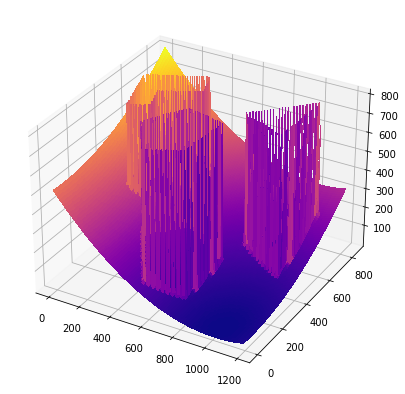

In [342]:
# Juntando tudo

k_att = 0.001

k_rep = 500.0

rho = 50.0 # raio de influ√™ncia

# Discretiza√ß√£o do espa√ßo (para visualiza√ß√£o)

xvalues = np.linspace(0,largura,500)

yvalues = np.linspace(0,altura,500)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

# Potencial atrator
zvalues = U_att(xgrid, ygrid, q_f)

cap = zvalues.max()

# Potencial repulsivo
for o in O:
    zvalues += U_rep_obs(xgrid, ygrid, o)

zvalues[zvalues > cap] = cap # vamos limitar para poder visualizar (valores de U tendem a infinito)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por efici√™ncia)
                       linewidth=0, antialiased=False);

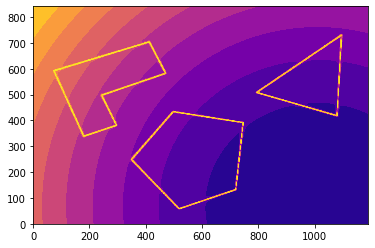

In [343]:
plt.contourf(xgrid,ygrid,zvalues,10, cmap=cm.plasma);

## Planejamento de trajet√≥ria por campo potencial

Trajet√≥ria √© obtida como sequ√™ncia de pontos obtidos pelo algoritmo de **descida do gradiente**:
$$
  q_{t+1} = q_t - \alpha \nabla U(q_t)
$$

O algoritmo converge para ponto estacion√°rio $\nabla(q) = 0$. Na pr√°tica, terminamos o algoritmo quando $||\nabla|| < \epsilon$.

In [413]:
def grad(q):
    ''' Calcula gradiente de potencial no ponto q. '''
    # Potencial atrator (meta)
    G = k_att*(q-q_f)
    # Potenciais repulsores
    for o in O: # para cada obst√°culo
        # Calcula dist√¢ncia de ponto q a objeto
        dist = np.Infinity
        a = o[:,-1]
        p = a[:] # ponto mais pr√≥ximo
        for i in range(o.shape[1]):
            b = o[:,i]
            # proje√ß√£o do ponto (x,y) na reta que passa por ab
            ab = b-a
            #print(q, a, b, ab, q-a, np.dot(q-a,ab), np.dot(ab,ab))
            t = np.dot(q-a,ab)/np.dot(ab,ab)
            #print(t)
            if 0 < t < 1:
                n = a + t*ab
            elif t < 0:
                n = a
            else:
                n = b
            d = np.sqrt(np.dot(q-n,q-n))
            if d < dist:
                dist = d
                p = n[:]
            # pr√≥xima aresta
            a = b
        # Calcula potencial repulsivo
        if dist < rho: # se dentro do raio de influ√™ncia
            G -= k_rep*(1/dist-1/rho)*(q-p)/dist**3
    return G

1019 itera√ß√µes.


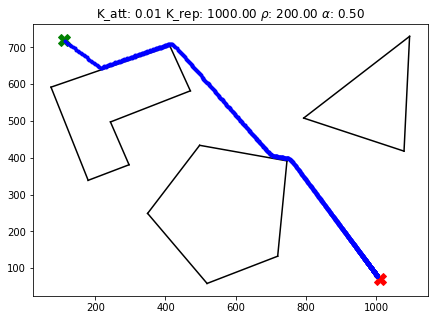

In [479]:
q_i   = np.array([110, 720]) # posi√ß√£o inicial

q_f   = np.array([1010, 70]) # posi√ß√£o final (desejada)

k_att = 0.01 # constante de atra√ß√£o

k_rep = 1000.0 # constante de repuls√£o

rho = 200.0 # raio de influ√™ncia

a = 0.5 # tamanho do passo

# Vamos exibir os obst√°culos e posi√ß√µes inicial e final
ar = largura/altura
plt.figure(figsize=(5*ar,5))
plt.title(rf"K_att: {k_att:.2f} K_rep: {k_rep:.2f} $\rho$: {rho:.2f} $\alpha$: {a:.2f}")
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);

# Descida do gradiente

q = q_i[:]
g = grad(q)
k = 0
while np.dot(g,g) > 0.01:
    q = q - a*g
    plt.plot(q[0], q[1], color='b', marker='o', markersize=3);
    g = grad(q)
    k += 1
    if k > 10000: # evita la√ßo infinito
        break
print(f"{k} itera√ß√µes.")

### üí°Sua vez

Modifique os par√¢metros do algoritmo ($K_\text{att}$, $K_\text{rep}$, $\rho$, $\alpha$) e reflita sobre as mudan√ßas na trajet√≥rias obtidas. Considere aspectos como:

- N√∫mero de itera√ß√µes (= pontos da trajet√≥ria)
- Dist√¢ncia m√≠nima aos obst√°culos
- Converg√™ncia (chegou na meta?) e instabilidade (movimentos bruscos ou inv√°lidos)

## Executando o plano

Vamos agora projetar um controlador para executar a trajet√≥ria. A trajet√≥ria gerada pode ser fornecida como refer√™ncia est√°tica, e controlada por um seguidor de linha ou pode ser computada din√¢micamente em rela√ß√£o a pose do rob√¥ em cada instante. Vamos adotar essa segunda abordagem, que aproveita a capacidade de campos potenciais fazerem planejamento em ambientes din√¢micos de maneira eficiente.

Nossa abordagem ser√° projetar um controlador de seguidor de ponto:
$$
u(t) = \begin{bmatrix} v \\ \omega \end{bmatrix} = \begin{bmatrix} K_v d \\ K_a \gamma \end{bmatrix} \, ,
$$
onde $d$ e $\gamma$ s√£o a dist√¢ncia e o √¢ngulo em rela√ß√£o √† pose atual ao ponto dado pela regra do gradiente no pr√≥ximo instante ($q_{t+1} = q_t - \alpha \nabla U(q_t)$), e $K_v$ e $K_a$ s√£oos ganhos do controlador proporcional.

In [626]:
from DifferentialDrive import DifferentialRobot

In [663]:
robot = DifferentialRobot(x0 = np.array([110., 720., .0]), max_speed=30., max_acc=100.) # pose inicial

q_f   = np.array([1010, 70]) # posi√ß√£o final (desejada)

k_att = 0.02 # constante de atra√ß√£o

k_rep = 7000.0 # constante de repuls√£o

rho = 300.0 # raio de influ√™ncia

a = 0.9 # tamanho do passo

Kv = 1.1 # ganho do controlador proporcional para a velocidade
Ka = 5. # ganho do controlador proporcional para a taxa de rota√ß√£o

it = 0
while True:
    # Localiza√ß√£o: obtenha posi√ß√£o da pose do rob√¥
    q = np.array([robot.x[0], robot.x[1]])    
    # C√°lculo do gradiente
    g = grad(q)
    if np.dot(g,g) < 0.01: # se pr√≥ximo a ponto estacion√°rio, pare
        print('Chegou em ponto estacion√°rio')        
        break        
    m = q - a*g # m √© ponto de refer√™ncia a ser seguido
    # seguir ponto m
    d = np.sqrt(np.dot(q-m,q-m)) # dist√¢ncia a ponto
    theta = np.arctan2(m[1]-q[1],m[0]-q[0])-robot.x[2] # √¢ngulo entre orienta√ß√£o e ponto    
    # enviar sinal controle
    robot.forward(Kv*d, Ka*theta)     
    it += 1
    if it > 10000: # evita la√ßo infinito
        print('No. max. de itera√ß√µes alcan√ßado')
        break   
        
print('Posi√ß√£o final:', robot.x)
print('Itera√ß√µes:', it)

Chegou em ponto estacion√°rio
Posi√ß√£o final: [ 1.00699690e+03  7.39892712e+01 -9.25467526e-01]
Itera√ß√µes: 2930


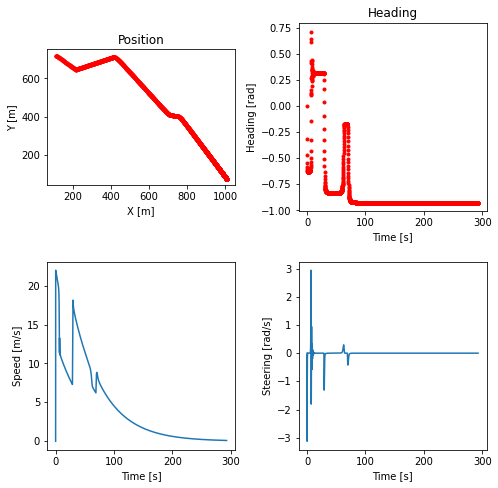

In [664]:
robot.plot();

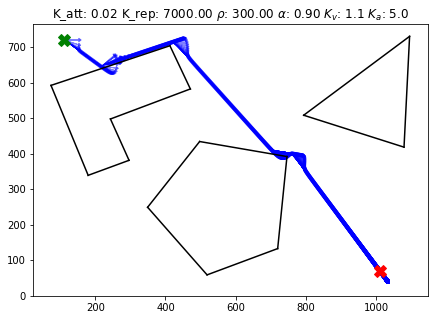

In [665]:
# Vamos exibir a trajet√≥ria executada
%matplotlib inline

ar = largura/altura
fig = plt.figure(figsize=(5*ar,5))
plt.title(rf"K_att: {k_att:.2f} K_rep: {k_rep:.2f} $\rho$: {rho:.2f} $\alpha$: {a:.2f} $K_v$: {Kv} $K_a$: {Ka}")
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);
for x in robot.x_hist:
    plt.arrow(x[0], x[1], 50*np.cos(x[2]), 50*np.sin(x[2]), length_includes_head=True, head_width=10, head_length=7, color='b', alpha=0.5)    

In [666]:
# Podemos visualizar a trajet√≥ria em forma de v√≠deo

%matplotlib notebook
from IPython import display  
import matplotlib.animation as animation

def animate(i):
    line.set_data(robot.x_hist[i][0], robot.x_hist[i][1])
    return line, 

ar = largura/altura
fig = plt.figure(figsize=(5*ar,5))
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);
line, = plt.plot(robot.x_hist[0][0], robot.x_hist[0][1], color='b', marker='o', markersize=5)

ani = animation.FuncAnimation(
    fig, animate, len(robot.x_hist), interval=robot.dt*100, blit=True) # modifique o valor 100 para aumentar/diminuir tempo de anima√ß√£o
# ani.save("movie.mp4") # descomente para salvar v√≠deo
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.show()

<IPython.core.display.Javascript object>

### üí°Sua vez

Modifique os ganhos do controlador e reflita sobre as mudan√ßas na trajet√≥ria obtida. Considere aspectos como:

- Instabilidade do rob√¥
- Suavidade dos movimentos (acelera√ß√µes linear e angular)
- Erro em regime
- Erro proporcional pr√≥xima √† meta

Sugira melhorias para tornar a trajet√≥ria mais suave e curta.